# CRIANDO O BANCO COM DADOS DA APi


In [ ]:
from IPython.display import Javascript

# Defina o novo limite de taxa de dados de saída
new_limit = 1000000000  # 10 MB/s

# Execute o JavaScript para configurar o novo limite
Javascript(f"google.colab.output.setIOPubDataRateLimit({new_limit})")

<IPython.core.display.Javascript object>

Para começar, vamos criar o banco de dados "vacinados", utilizando os dados da API do data-set escolhido.


Interessante https://app.powerbi.com/view?r=eyJrIjoiNmI1NDcyYTUtYTlhMS00ZWFlLWE4MTYtOGQzM2RkMzgyOTAxIiwidCI6ImQ1ZTU0MGZmLTkzNzAtNGNhMi04YmVmLWQwMzcyMWQxM2MwNSJ9&pageName=ReportSectiondc8ac2b66d0753222000

Dataset escolhido: http://dados.recife.pe.gov.br/dataset/perfil-das-pessoas-vacinadas-covid-19/resource/ca7fb968-3a2c-44ff-a2e8-730d1a689407

In [ ]:
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, min as spark_min, max as spark_max, regexp_replace, to_date, isnull, when, count

# URL do Dataset
url = 'http://dados.recife.pe.gov.br/dataset/7ccb3816-0d62-49e1-b39a-3159870883b0/resource/ca7fb968-3a2c-44ff-a2e8-730d1a689407/download/vacinados.csv'

# Nome dado ao arquivo gerado
output = 'vacinados.csv'

# Download do arquivo
urllib.request.urlretrieve(url, output)

# Inicialização do SparkSession
spark = SparkSession.builder.appName('vacinados').getOrCreate()

# Configuração para não omitir o conteúdo de uma célula ao utilizar Pandas
pd.set_option('display.max_colwidth', None)

# Criação do Dataframe Spark
df = spark.read.csv('vacinados.csv', encoding='ISO-8859-1' ,sep=';', header=True, inferSchema=True)
df.printSchema()

df = df.withColumn("sexo", regexp_replace("sexo", "Ã", "Í"))
df = df.withColumn("raca_cor", regexp_replace("raca_cor", "Ã", "Í"))
df = df.withColumn("municipio", regexp_replace("municipio", "Ã", "Á"))
df = df.withColumn("grupo", regexp_replace("grupo", "Ã", "Í"))

df = df.withColumn("data_vacinacao", to_date(df["data_vacinacao"], "dd/MM/yyyy"))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=bf8c2aed31be04787ce2f8c885b3c19d467cb4900940875402ae14bb9d2ac4c9
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
root
 |-- faixa_etaria: string (nullable = true)
 |-- idade: string (nullable = true)
 |-- sexo: string (nullable = true)
 |-- raca_cor: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- grupo: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- lote: string (nullable = true)
 |-- vacina_fabricante: string (nullable = true)
 |-- descricao_dose: string (nullable = true)
 |-- cnes: string (nullable = true)
 |-- sistema_origem: string (nullable = true)
 |-- data_vacinacao: string (nullable = true)



Vamos começar nossa análise exploratória:

In [ ]:
df_pandas = df.toPandas()

In [ ]:
print(df_pandas.info())
# um comando que vai dar as informações gerais da nossa base de dados, valores nulos e tipos de dados.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1466240 entries, 0 to 1466239
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   faixa_etaria       1466237 non-null  object
 1   idade              1466237 non-null  object
 2   sexo               1466190 non-null  object
 3   raca_cor           1465971 non-null  object
 4   municipio          1466227 non-null  object
 5   grupo              1466232 non-null  object
 6   categoria          163073 non-null   object
 7   lote               1465213 non-null  object
 8   vacina_fabricante  1466220 non-null  object
 9   descricao_dose     1466215 non-null  object
 10  cnes               1466209 non-null  object
 11  sistema_origem     1466200 non-null  object
 12  data_vacinacao     0 non-null        object
dtypes: object(13)
memory usage: 145.4+ MB
None


Agora outro comando que nos fornece um resumo estatistico do nosso banco:

Contagem (count): número de observações não nulas.

Média (mean): média aritmética dos valores.

Desvio padrão (std): medida de dispersão em torno da média.

Valor mínimo (min): menor valor na variável.

Quartis (25%, 50%, 75%): valores que dividem a distribuição em quartis, representando o primeiro quartil (Q1), mediana (Q2) e terceiro quartil (Q3).

Valor máximo (max): maior valor na variável.

In [ ]:
df.describe().show()

+-------+------------+------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+
|summary|faixa_etaria|             idade|                sexo|            raca_cor|          municipio|               grupo|           categoria|                lote|   vacina_fabricante|    descricao_dose|                cnes|      sistema_origem|
+-------+------------+------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+
|  count|     1466237|           1466237|             1466190|             1465971|            1466227|             1466232|              163073|             1465213|             1466220|           1466215|             1466209|             1466200|
|   

Agora vamos utilizar o comando display para mostrar os 20 primeiros

In [ ]:
df.show()

+------------+-----+---------+--------+---------+--------------------+--------------------+----------+--------------------+--------------+--------------------+--------------+--------------+
|faixa_etaria|idade|     sexo|raca_cor|municipio|               grupo|           categoria|      lote|   vacina_fabricante|descricao_dose|                cnes|sistema_origem|data_vacinacao|
+------------+-----+---------+--------+---------+--------------------+--------------------+----------+--------------------+--------------+--------------------+--------------+--------------+
|40 a 44 anos|   42|MASCULINO|   PRETA|   RECIFE|PESSOAS COM COMOR...|PESSOAS COM OBESI...|    FL4222|3 - COMIRNATY (PF...|             3|DS 2: CNES: 68970...|Conecta Recife|          NULL|
|80 a 84 anos|   82|MASCULINO|  BRANCA|   RECIFE|              IDOSOS|                NULL|219VCD288Z|2 - CHADOX1NCOV-1...|             3|DS 5: CNES: 00070...|Conecta Recife|          NULL|
|35 a 39 anos|   38| FEMININO| AMARELA|   RECIFE|P

Agora para visualizar o periodo da analise:

In [ ]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Calcular e exibir a data de início e fim da vacinação
inicio = df.select(spark_min("data_vacinacao")).collect()[0][0]
print("Data de inicio", inicio)
fim = df.select(spark_max("data_vacinacao")).collect()[0][0]
print("Data final", fim)

+------------+-----+----+--------+---------+-----+---------+----+-----------------+--------------+----+--------------+--------------+
|faixa_etaria|idade|sexo|raca_cor|municipio|grupo|categoria|lote|vacina_fabricante|descricao_dose|cnes|sistema_origem|data_vacinacao|
+------------+-----+----+--------+---------+-----+---------+----+-----------------+--------------+----+--------------+--------------+
|           3|    3|  50|     269|       13|    8|  1303167|1027|               20|            25|  31|            40|       1466240|
+------------+-----+----+--------+---------+-----+---------+----+-----------------+--------------+----+--------------+--------------+

Data de inicio None
Data final None


#  Tratamento de Dados:

Vamos visualizar os dados nulos da tabela:

In [ ]:
from pyspark.sql.functions import col, count

# Verifica valores nulos em cada coluna
null_counts = df.select([count(col(c).isNull().alias(c)) for c in df.columns])

# Exibe os resultados
null_counts.show()

+---------------------------------------------+-------------------------------+-----------------------------+-------------------------------------+---------------------------------------+-------------------------------+---------------------------------------+-----------------------------+-------------------------------------------------------+-------------------------------------------------+-----------------------------+-------------------------------------------------+-------------------------------------------------+
|count((faixa_etaria IS NULL) AS faixa_etaria)|count((idade IS NULL) AS idade)|count((sexo IS NULL) AS sexo)|count((raca_cor IS NULL) AS raca_cor)|count((municipio IS NULL) AS municipio)|count((grupo IS NULL) AS grupo)|count((categoria IS NULL) AS categoria)|count((lote IS NULL) AS lote)|count((vacina_fabricante IS NULL) AS vacina_fabricante)|count((descricao_dose IS NULL) AS descricao_dose)|count((cnes IS NULL) AS cnes)|count((sistema_origem IS NULL) AS sistema_origem)

Visualizando as estatisticas de idades

In [ ]:
from pyspark.sql.functions import col

# Calculando estatísticas descritivas para a coluna 'idade'
idade_stats = df.select('idade').describe()

# Exibindo as estatísticas descritivas
idade_stats.show()


+-------+------------------+
|summary|             idade|
+-------+------------------+
|  count|           1466237|
|   mean| 38.63979525722431|
| stddev|21.257118321169234|
|    min|              -952|
|    max|            RECIFE|
+-------+------------------+



In [ ]:
from pyspark.sql.functions import col, when

# Encontrar índices onde 'municipio' é igual a '2'
indices_to_replace = df.filter(col('municipio') == '2').select('municipio').collect()

# Exibir os índices
print(indices_to_replace)

# Substituir valores na coluna 'municipio'
df = df.withColumn('municipio', when(col('municipio').isin('2', '3', '4', '5'), 'NÃO INFORMADO').otherwise(col('municipio')))


[Row(municipio='2'), Row(municipio='2'), Row(municipio='2'), Row(municipio='2'), Row(municipio='2'), Row(municipio='2'), Row(municipio='2'), Row(municipio='2'), Row(municipio='2'), Row(municipio='2'), Row(municipio='2'), Row(municipio='2'), Row(municipio='2'), Row(municipio='2'), Row(municipio='2'), Row(municipio='2'), Row(municipio='2'), Row(municipio='2'), Row(municipio='2'), Row(municipio='2'), Row(municipio='2'), Row(municipio='2'), Row(municipio='2'), Row(municipio='2'), Row(municipio='2'), Row(municipio='2'), Row(municipio='2'), Row(municipio='2')]


In [ ]:
from pyspark.sql.functions import col

# Obtém os valores únicos na coluna 'municipio'
unique_municipios = df.select('municipio').distinct().collect()

# Exibe os valores únicos
for row in unique_municipios:
    print(row['municipio'])

GRAVATÁ
XEXÁU
TEIXEIRA DE FREITAS
TOBIAS BARRETO
CAMARAJIBE
FERREIROS
CAMPO NOVO DO PARECIS
IPOJUCA
GARANHUNS
SIRINHAÁM
RIO DE JANEIRO
SÁO JOSÁ DA COROA GRANDE
1875740
Conecta Recife
GRAVATA
CRUZ DE REBOLSAS
JUREMA
ARAÁOIABA
VITÁRIA DE SANTO ANTÁO
ÁGUA PRETA
SÁO JOSÁ DO EGITO
SANTA CRUZ DO CAPIBARIBE
MOGI DAS CRUZES
LENÁÁIS PAULISTA
TAQUARITINGA DO NORTE
SANTARÁM
DIVINÁPOLIS
SÁO BENTO DO UNA
PALMAS
LAGOA DOS GATOS
NAVEGANTES
ANICUNS
SOSSEGO
OURICURI
BAÁA FORMOSA
SÁO LOURENÁO
ARACAJU
PIRACICABA
RIBEIRAO
LUIS EDUARDO MAGALHÁES BAHIA
CAPINÁPOLIS
LAJEDO
FRANCISCO MORATO
JUAZEIRO
AFOGADOS DA INGAZEIRA
JOAO PESSOA
JIJOCA DE JERICOACOARA
FLORES
SUMARÁ
NAZARÁ DA MATA
MOSSORÁ
ARAGUAÁNA
CASINHAS
TERESINA
HORTOLÁNDIA
GAMELEIRA
SANTA MARIA
PAULISTA
RIO BRANCO
ARACATI
ARARIPINA
SÁO MIGUEL DOS CAMPOS
FLORIANÁPOLIS
MORRO DO CHAPÁU
ALAGOINHAS
MATO GROSSO
PALMARES
PICUÁ
ILHÁUS
CARAPICUÁBA
TRACUNHAÁM
PAUDALHO
CARNAÁBA
GUARULHOS
CUMARU
VESPASIANO
ITÁPOLIS
VALE DAS PEDRE

In [ ]:
idadeErrada = pd.read_sql("select * from vacinados where idade < 0;", connection)
print(idadeErrada)

#visualizando dados da coluna com idade invalida


AnalysisException: [TABLE_OR_VIEW_NOT_FOUND] The table or view `vacinados` cannot be found. Verify the spelling and correctness of the schema and catalog.
If you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.
To tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABLE IF EXISTS.; line 1 pos 14;
'Project [*]
+- 'Filter ('idade < 0)
   +- 'UnresolvedRelation [vacinados], [], false


É possivel perceber que existe uma idade minima de -952, logo invalido precisa ser trocada

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit

# Inicialização do SparkSession
spark = SparkSession.builder.appName('tratamento-idade').getOrCreate()

# Carregando o DataFrame do CSV
df = spark.read.csv('vacinados.csv', encoding='ISO-8859-1', sep=';', header=True, inferSchema=True)

# Calculando a mediana da idade válida (idade >= 0)
mediana_idade = df.filter(col('idade') >= 0).agg({'idade': 'median'}).collect()[0][0]

# Substituindo valores negativos, vazios e nulos pela mediana da idade
df = df.withColumn('idade',
                   when(col('idade') < 0, lit(mediana_idade))
                   .when(col('idade').isNull(), lit(mediana_idade))
                   .when(col('idade') == ' ', lit(mediana_idade))
                   .otherwise(col('idade')))

# Verificando estatísticas descritivas após o tratamento
df.select('idade').describe().show()


+-------+-----------------+
|summary|            idade|
+-------+-----------------+
|  count|          1466240|
|   mean|38.64047460396813|
| stddev|21.24134757966234|
|    min|                0|
|    max|           RECIFE|
+-------+-----------------+



Verificando a presença de idades nulas na tabela

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Inicialização do SparkSession
spark = SparkSession.builder.appName('verificacao-vazios').getOrCreate()

# Carregando o DataFrame do CSV
df = spark.read.csv('vacinados.csv', encoding='ISO-8859-1', sep=';', header=True, inferSchema=True)

# Contando registros com valores NaN na coluna 'idade'
count_nan = df.filter(df['idade'].isNull()).count()
print(f"Quantidade de registros com idade vazia: {count_nan}")

# Contando registros com valores em branco na coluna 'idade'
count_vazio = df.filter((col('idade') == '') | (col('idade').isNull())).count()
print(f"Quantidade de registros com idade em branco: {count_vazio}")


Quantidade de registros com idade vazia: 3
Quantidade de registros com idade em branco: 3


In [ ]:
from pyspark.sql import SparkSession

# Inicialização do SparkSession
spark = SparkSession.builder.appName('exibir-tipos').getOrCreate()

# Carregando o DataFrame do CSV
df = spark.read.csv('vacinados.csv', encoding='ISO-8859-1', sep=';', header=True, inferSchema=True)

# Obtendo os tipos de dados das colunas
tipos_de_dados = df.dtypes

# Convertendo para DataFrame do Pandas para exibição em forma de tabela
import pandas as pd
pd_tipos_de_dados = pd.DataFrame(tipos_de_dados, columns=['Coluna', 'Tipo de Dados'])

# Exibindo como tabela
print(pd_tipos_de_dados)


               Coluna Tipo de Dados
0        faixa_etaria        string
1               idade        string
2                sexo        string
3            raca_cor        string
4           municipio        string
5               grupo        string
6           categoria        string
7                lote        string
8   vacina_fabricante        string
9      descricao_dose        string
10               cnes        string
11     sistema_origem        string
12     data_vacinacao        string


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date

# Inicialização do SparkSession
spark = SparkSession.builder.appName('exibir-tipos').getOrCreate()

# Carregando o DataFrame do CSV
df = spark.read.csv('vacinados.csv', encoding='ISO-8859-1', sep=';', header=True, inferSchema=True)

# Convertendo a coluna 'data_vacinacao' para tipo datetime
df = df.withColumn('data_vacinacao', to_date(df['data_vacinacao'], 'dd/MM/yyyy'))

# Exibindo os tipos de dados das colunas
df.printSchema()


root
 |-- faixa_etaria: string (nullable = true)
 |-- idade: string (nullable = true)
 |-- sexo: string (nullable = true)
 |-- raca_cor: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- grupo: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- lote: string (nullable = true)
 |-- vacina_fabricante: string (nullable = true)
 |-- descricao_dose: string (nullable = true)
 |-- cnes: string (nullable = true)
 |-- sistema_origem: string (nullable = true)
 |-- data_vacinacao: date (nullable = true)



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count

# Exibindo a distribuição de raca_cor
df_grouped = df.groupBy('raca_cor').agg(count('*').alias('contagem')).orderBy('contagem', ascending=False)

# Coletando os resultados para exibição
resultados = df_grouped.collect()

# Exibindo os resultados
print("\nDistribuição de raca_cor:")
for row in resultados:
    print(f"{row['raca_cor']}: {row['contagem']}")



Distribuição de raca_cor:
2022-08-09 00:00:00.0: 1
DS 1: CNES: 000507 - POLICLÃNICA GOUVEIA DE BARROS: 1
DS 6: CNES: 0001392 - MIGUEL DE LIMA VALVERDE.: 1
21PVCD385W: 1
DS 2: CNES: 6897029 - POLICLÃNICA SALOMÃO KELNER: 1
2022-07-30 00:00:00.0: 1
BRDS 6: CNES: 0001392 - MIGUEL DE LIMA VALVERDE.: 1
3 - COMIRNATY (PFIZER): 1
4 - JANSSEN COVID-19 VACCINE (JOHNSON & JOHNSON): 2
Conecta Recife: 4
None: 269
ÃNDIGENA: 1202
INDÃGENA: 3117
NÃO INFORMADO: 8990
AMARELA: 54381
PRETA: 172303
BRANCA: 529047
PARDA: 696917


In [ ]:
from pyspark.sql.functions import col, count

# Contando valores vazios na coluna 'raca_cor'
vazios = df.filter(col('raca_cor') == '').count()

# Exibindo a contagem de valores vazios
print(f"\nQuantidade de valores vazios na coluna 'raca_cor': {vazios}")



Quantidade de valores vazios na coluna 'raca_cor': 0


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when


# Preenchendo valores vazios na coluna 'raca_cor' com 'NÃO INFORMADO'
df = df.withColumn('raca_cor', when(col('raca_cor') == '', 'NÃO INFORMADO').otherwise(col('raca_cor')))

# Exibindo os resultados
df.show(5)  # Exibe os primeiros 5 registros para verificar o preenchimento

# Caso queira salvar as alterações de volta para um novo arquivo CSV, por exemplo
# df.write.csv('vacinados_preenchido.csv', header=True, mode='overwrite')



+------------+-----+---------+--------+---------+--------------------+--------------------+----------+--------------------+--------------+--------------------+--------------+--------------------+
|faixa_etaria|idade|     sexo|raca_cor|municipio|               grupo|           categoria|      lote|   vacina_fabricante|descricao_dose|                cnes|sistema_origem|      data_vacinacao|
+------------+-----+---------+--------+---------+--------------------+--------------------+----------+--------------------+--------------+--------------------+--------------+--------------------+
|40 a 44 anos|   42|MASCULINO|   PRETA|   RECIFE|PESSOAS COM COMOR...|PESSOAS COM OBESI...|    FL4222|3 - COMIRNATY (PF...|             3|DS 2: CNES: 68970...|Conecta Recife|2022-01-04 00:00:...|
|80 a 84 anos|   82|MASCULINO|  BRANCA|   RECIFE|              IDOSOS|                NULL|219VCD288Z|2 - CHADOX1NCOV-1...|             3|DS 5: CNES: 00070...|Conecta Recife|2022-03-09 00:00:...|
|35 a 39 anos|   38|

In [ ]:

from pyspark.sql import SparkSession

# Obtendo os valores únicos na coluna 'raca_cor'
valores_unicos = df.select('raca_cor').distinct().collect()

# Exibindo os valores únicos
for row in valores_unicos:
    print(row['raca_cor'])


2022-08-09 00:00:00.0
Conecta Recife
BRANCA
DS 1: CNES: 000507 - POLICLÃNICA GOUVEIA DE BARROS
DS 6: CNES: 0001392 - MIGUEL DE LIMA VALVERDE.
ÃNDIGENA
AMARELA
INDÃGENA
NÃO INFORMADO
PARDA
21PVCD385W
DS 2: CNES: 6897029 - POLICLÃNICA SALOMÃO KELNER
2022-07-30 00:00:00.0
PRETA
4 - JANSSEN COVID-19 VACCINE (JOHNSON & JOHNSON)
BRDS 6: CNES: 0001392 - MIGUEL DE LIMA VALVERDE.
3 - COMIRNATY (PFIZER)
None


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

# Substituindo o valor 'ÍNDIGENA' por 'INDÍGENA' na coluna 'raca_cor'
df = df.withColumn('raca_cor', when(col('raca_cor') == 'ÍNDIGENA', 'INDÍGENA').otherwise(col('raca_cor')))

+------------+-----+---------+--------+---------+--------------------+--------------------+----------+--------------------+--------------+--------------------+--------------+--------------------+
|faixa_etaria|idade|     sexo|raca_cor|municipio|               grupo|           categoria|      lote|   vacina_fabricante|descricao_dose|                cnes|sistema_origem|      data_vacinacao|
+------------+-----+---------+--------+---------+--------------------+--------------------+----------+--------------------+--------------+--------------------+--------------+--------------------+
|40 a 44 anos|   42|MASCULINO|   PRETA|   RECIFE|PESSOAS COM COMOR...|PESSOAS COM OBESI...|    FL4222|3 - COMIRNATY (PF...|             3|DS 2: CNES: 68970...|Conecta Recife|2022-01-04 00:00:...|
|80 a 84 anos|   82|MASCULINO|  BRANCA|   RECIFE|              IDOSOS|                NULL|219VCD288Z|2 - CHADOX1NCOV-1...|             3|DS 5: CNES: 00070...|Conecta Recife|2022-03-09 00:00:...|
|35 a 39 anos|   38|

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

# Substituindo valores em branco por 'NÃO INFORMADO' na coluna 'raca_cor'
df = df.withColumn('raca_cor', when(col('raca_cor') == '', 'NÃO INFORMADO').otherwise(col('raca_cor')))

+------------+-----+---------+--------+---------+--------------------+--------------------+----------+--------------------+--------------+--------------------+--------------+--------------------+
|faixa_etaria|idade|     sexo|raca_cor|municipio|               grupo|           categoria|      lote|   vacina_fabricante|descricao_dose|                cnes|sistema_origem|      data_vacinacao|
+------------+-----+---------+--------+---------+--------------------+--------------------+----------+--------------------+--------------+--------------------+--------------+--------------------+
|40 a 44 anos|   42|MASCULINO|   PRETA|   RECIFE|PESSOAS COM COMOR...|PESSOAS COM OBESI...|    FL4222|3 - COMIRNATY (PF...|             3|DS 2: CNES: 68970...|Conecta Recife|2022-01-04 00:00:...|
|80 a 84 anos|   82|MASCULINO|  BRANCA|   RECIFE|              IDOSOS|                NULL|219VCD288Z|2 - CHADOX1NCOV-1...|             3|DS 5: CNES: 00070...|Conecta Recife|2022-03-09 00:00:...|
|35 a 39 anos|   38|

In [ ]:
from pyspark.sql import SparkSession

# Obtendo os valores únicos na coluna 'raca_cor'
valores_unicos = df.select('raca_cor').distinct().collect()

# Exibindo os valores únicos
for row in valores_unicos:
    print(row['raca_cor'])


2022-08-09 00:00:00.0
Conecta Recife
BRANCA
DS 1: CNES: 000507 - POLICLÃNICA GOUVEIA DE BARROS
DS 6: CNES: 0001392 - MIGUEL DE LIMA VALVERDE.
ÃNDIGENA
AMARELA
INDÃGENA
NÃO INFORMADO
PARDA
21PVCD385W
DS 2: CNES: 6897029 - POLICLÃNICA SALOMÃO KELNER
2022-07-30 00:00:00.0
PRETA
4 - JANSSEN COVID-19 VACCINE (JOHNSON & JOHNSON)
BRDS 6: CNES: 0001392 - MIGUEL DE LIMA VALVERDE.
3 - COMIRNATY (PFIZER)
None


# Consultas de dados

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Filtrando os registros onde a idade é menor que 0
idade_negativa = df.filter(col('idade') < 0)

# Exibindo os resultados
idade_negativa.show()


+------------+-----+---------+--------+---------+--------------------+---------+----------+--------------------+--------------+--------------------+--------------+--------------------+
|faixa_etaria|idade|     sexo|raca_cor|municipio|               grupo|categoria|      lote|   vacina_fabricante|descricao_dose|                cnes|sistema_origem|      data_vacinacao|
+------------+-----+---------+--------+---------+--------------------+---------+----------+--------------------+--------------+--------------------+--------------+--------------------+
|        NULL| -952|MASCULINO|  BRANCA|   OLINDA|PESSOAS COM COMOR...|     NULL|223VCD066W|2 - CHADOX1NCOV-1...|             4|DS 1: CNES: 00050...|Conecta Recife|2022-11-04 00:00:...|
+------------+-----+---------+--------+---------+--------------------+---------+----------+--------------------+--------------+--------------------+--------------+--------------------+



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Convertendo a coluna 'idade' para tipo Integer (supondo que a coluna 'idade' contenha apenas valores numéricos válidos)
df = df.withColumn('idade', df['idade'].cast('integer'))

# Calculando a mediana da coluna 'idade'
mediana = df.approxQuantile('idade', [0.5], 0.0)[0]
print(f"Mediana da idade: {mediana}")


Mediana da idade: 40.0


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Calculando a moda da coluna 'idade'
moda = df.groupby('idade').count().orderBy(col('count').desc()).select('idade').first()[0]

# Exibindo a moda
print(f"Moda da idade: {moda}")


Moda da idade: 40


Exibição de grafico das vacinas fabricadas por mais usadas

<ipython-input-49-ae9c1fe965fd>:33: UserWarning: Glyph 129 (\x81) missing from current font.
  plt.tight_layout()


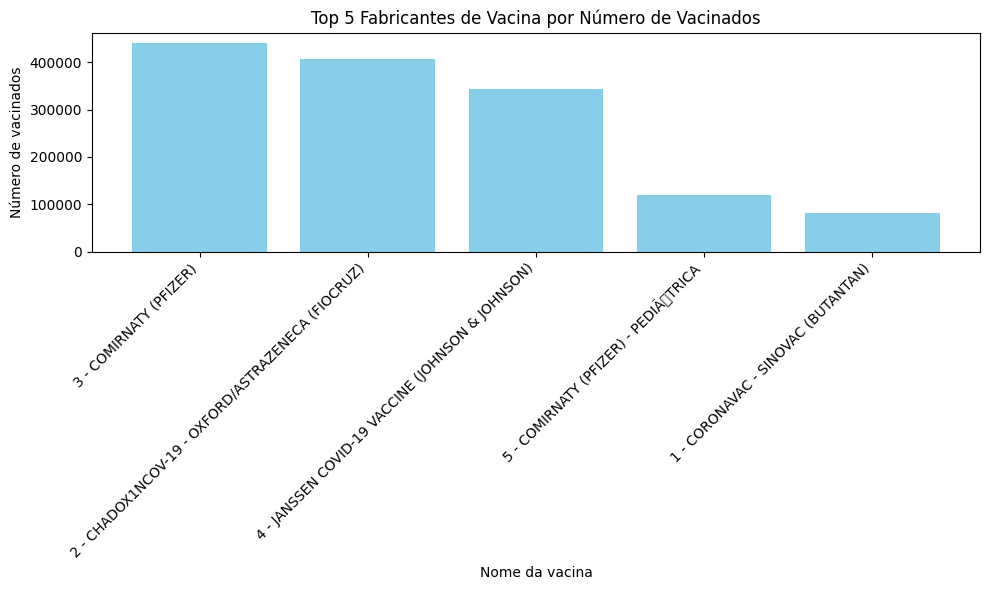

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Contagem dos vacinados por fabricante de vacina
contagem_vacina = df.groupBy('vacina_fabricante').count().orderBy(col('count').desc())

# Coletando os 5 primeiros resultados para plotagem
contagem_vacina_top5 = contagem_vacina.limit(5).collect()

# Preparando dados para plotagem
fabricantes = [row['vacina_fabricante'] for row in contagem_vacina_top5]
contagens = [row['count'] for row in contagem_vacina_top5]

# Convertendo para listas Python simples para garantir compatibilidade com Matplotlib
fabricantes = list(map(str, fabricantes))
contagens = list(map(int, contagens))

# Plotando o gráfico de barras usando Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(fabricantes, contagens, color='skyblue')
plt.xlabel('Nome da vacina')
plt.ylabel('Número de vacinados')
plt.title('Top 5 Fabricantes de Vacina por Número de Vacinados')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 154 (\x9a) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


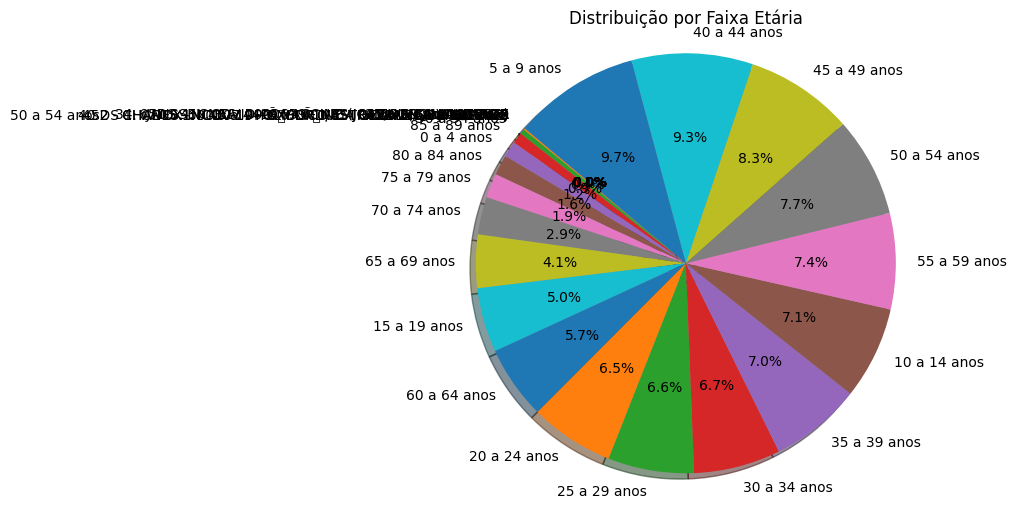

In [ ]:

# Agrupando e contando por faixa_etaria
contagem_faixa_etaria = df.groupBy('faixa_etaria').count().orderBy('count')

# Coletando os resultados para plotagem
dados = contagem_faixa_etaria.collect()

# Preparando dados para o gráfico de pizza
labels = [registro['faixa_etaria'] for registro in dados]
sizes = [registro['count'] for registro in dados]

# Criando o gráfico de pizza
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Garante que o gráfico de pizza seja desenhado como um círculo
plt.title('Distribuição por Faixa Etária')

# Mostrando o gráfico
plt.show()


In [ ]:
# Agrupando e contando por faixa_etaria
contagem_faixa_etaria = df.groupBy('faixa_etaria').count().orderBy('count')

# Coletando os resultados para cálculo das porcentagens
dados = contagem_faixa_etaria.collect()

# Calculando o total de ocorrências
total_ocorrencias = sum([ocorrencias for _, ocorrencias in dados])

# Calculando as porcentagens para cada faixa etária
faixa_porcentagens = [(faixa_etaria, (ocorrencias / total_ocorrencias) * 100) for faixa_etaria, ocorrencias in dados]

# Mostrando os resultados
for faixa_etaria, porcentagem in faixa_porcentagens:
    print(f"{faixa_etaria}: {porcentagem:.2f}%")


50 a 54 anoPARDA: 0.00%
40 2 - CHADOX1NCOV-19 - OXFORD/ASTRAZENECA (FIOCRUZ): 0.00%
65DS 4: CNES: 0000639 - UBS JOAQUIM CAVALCANTE: 0.00%
65 a 69 anos210527: 0.00%
35 a 39 ano1875740: 0.00%
50 a 54 anos2 - CHADOX1NCOV-19 - OXFORD/ASTRAZENECA (FIOCRUZ): 0.00%
34 - JANSSEN COVID-19 VACCINE (JOHNSON & JOHNSON): 0.00%
45DS 1: CNES: 000507 - POLICLÃNICA GOUVEIA DE BARROS: 0.00%
40 a 44PÃBLICO EM GERAL (18 a 59 anos): 0.00%
None: 0.00%
100 anos +: 0.02%
95 a 99 anos: 0.11%
90 a 94 anos: 0.38%
85 a 89 anos: 0.86%
0 a 4 anos: 1.21%
80 a 84 anos: 1.56%
75 a 79 anos: 1.87%
70 a 74 anos: 2.89%
65 a 69 anos: 4.11%
15 a 19 anos: 4.96%
60 a 64 anos: 5.66%
20 a 24 anos: 6.49%
25 a 29 anos: 6.62%
30 a 34 anos: 6.68%
35 a 39 anos: 7.03%
10 a 14 anos: 7.13%
55 a 59 anos: 7.39%
50 a 54 anos: 7.69%
45 a 49 anos: 8.29%
40 a 44 anos: 9.34%
5 a 9 anos: 9.72%


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 131 (\x83) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


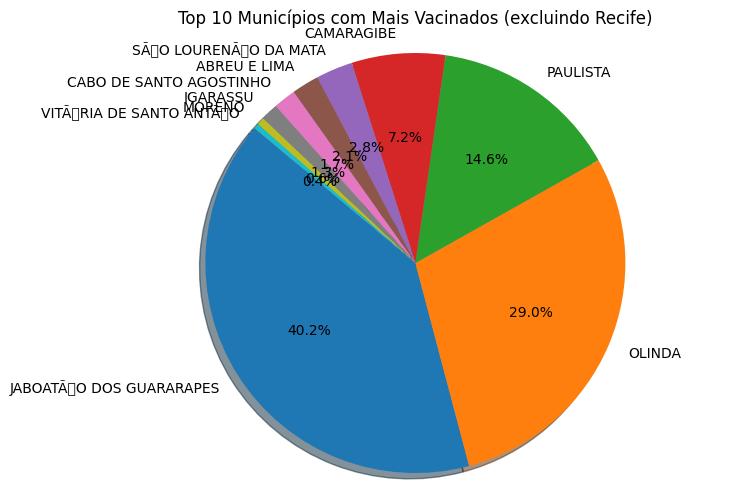

In [ ]:
# Filtrando os municípios que não são 'Recife' e agrupando por município
contagem_municipios = df.filter(~col('municipio').like('%RECIFE%')) \
                        .groupBy('municipio').count() \
                        .orderBy('count', ascending=False) \
                        .limit(10)

# Coletando os resultados para plotagem
dados = contagem_municipios.collect()

# Preparando dados para o gráfico de pizza
labels = [registro['municipio'] for registro in dados]
sizes = [registro['count'] for registro in dados]

# Criando o gráfico de pizza
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Garante que o gráfico de pizza seja desenhado como um círculo
plt.title('Top 10 Municípios com Mais Vacinados (excluindo Recife)')

# Mostrando o gráfico
plt.show()

In [ ]:
# Filtrando os municípios que não são 'Recife' e agrupando por município
contagem_municipios = df.filter(~col('municipio').like('%RECIFE%')) \
                        .groupBy('municipio').count() \
                        .orderBy('count', ascending=False)

# Coletando os resultados para cálculo das porcentagens
dados = contagem_municipios.collect()

# Calculando o total de ocorrências
total_ocorrencias = sum([ocorrencias for _, ocorrencias in dados])

# Calculando as porcentagens para cada município
municipios_porcentagens = [(municipio, (ocorrencias / total_ocorrencias) * 100) for municipio, ocorrencias in dados]

# Mostrando os resultados
for municipio, porcentagem in municipios_porcentagens:
    print(f"{municipio}: {porcentagem:.2f}%")

JABOATÃO DOS GUARARAPES: 36.37%
OLINDA: 26.24%
PAULISTA: 13.17%
CAMARAGIBE: 6.51%
SÃO LOURENÃO DA MATA: 2.56%
ABREU E LIMA: 1.91%
CABO DE SANTO AGOSTINHO: 1.57%
IGARASSU: 1.21%
MORENO: 0.53%
VITÃRIA DE SANTO ANTÃO: 0.34%
SÃO PAULO: 0.32%
IPOJUCA: 0.29%
PAUDALHO: 0.29%
CARPINA: 0.25%
CARUARU: 0.25%
JOÃO PESSOA: 0.24%
4: 0.21%
RIO DE JANEIRO: 0.20%
ESCADA: 0.16%
GARANHUNS: 0.15%
LIMOEIRO: 0.14%
GRAVATÃ: 0.14%
MACEIÃ: 0.13%
GOIANA: 0.13%
BRASÃLIA: 0.12%
JABOATAO: 0.12%
PETROLINA: 0.12%
FORTALEZA: 0.12%
ILHA DE ITAMARACÃ: 0.11%
SURUBIM: 0.11%
ITAPISSUMA: 0.10%
SALVADOR: 0.10%
NAZARÃ DA MATA: 0.09%
TIMBAÃBA: 0.09%
SIRINHAÃM: 0.09%
BOM JARDIM: 0.08%
5: 0.08%
JABOATAO DOS GUARARAPES: 0.08%
3: 0.08%
NATAL: 0.08%
BUENOS AIRES: 0.07%
JABOATÃO: 0.07%
BELO HORIZONTE: 0.07%
CAMPINA GRANDE: 0.07%
BARREIROS: 0.07%
MANAUS: 0.07%
CONDADO: 0.07%
2: 0.07%
ALIANÃA: 0.06%
RIBEIRÃO: 0.06%
ARCOVERDE: 0.06%
PALMARES: 0.05%
SERRA TALHADA: 0.05%
GLÃRIA DO GOITÃ: 0.05%
PASSIRA: 0.05%
BEZERROS:

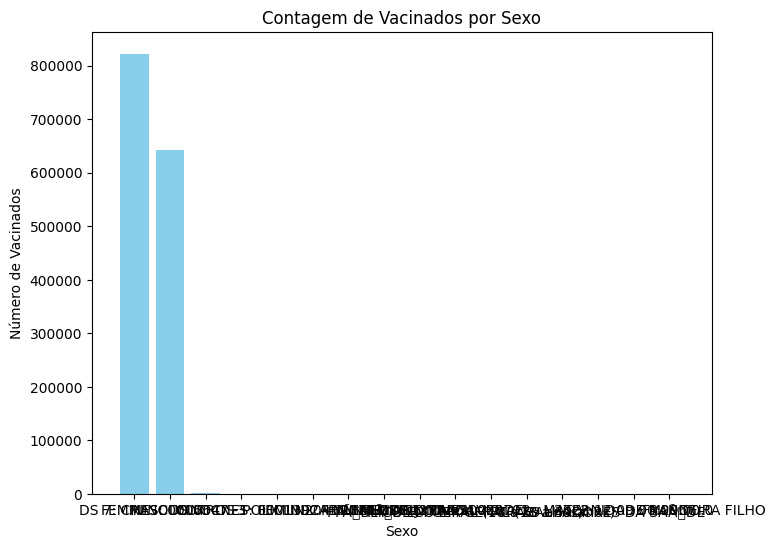

In [ ]:
# Contando os valores únicos na coluna 'sexo' e filtrando nulos
contagem_sexo = df.filter(df['sexo'].isNotNull()) \
                  .groupBy('sexo').count() \
                  .orderBy('count', ascending=False)

# Coletando os resultados para plotagem
dados = contagem_sexo.collect()

# Preparando dados para o gráfico de barras
sexos = [registro['sexo'] for registro in dados if registro['sexo'] is not None]
contagens = [registro['count'] for registro in dados if registro['sexo'] is not None]

# Criando o gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(sexos, contagens, color='skyblue')
plt.xlabel('Sexo')
plt.ylabel('Número de Vacinados')
plt.title('Contagem de Vacinados por Sexo')
plt.show()

<ipython-input-57-95ad422afd32>:18: UserWarning: Glyph 141 (\x8d) missing from current font.
  plt.tight_layout()  # Ajusta o layout para evitar cortar rótulos
<ipython-input-57-95ad422afd32>:18: UserWarning: Glyph 154 (\x9a) missing from current font.
  plt.tight_layout()  # Ajusta o layout para evitar cortar rótulos


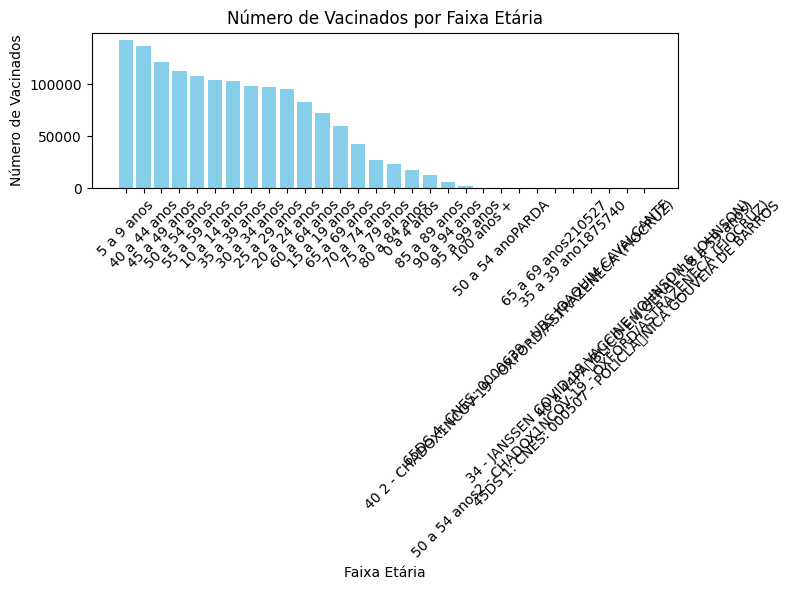

In [ ]:
# Contando os valores únicos na coluna 'faixa_etaria'
contagem_faixa_etaria = df.groupBy('faixa_etaria').count().orderBy('count', ascending=False)

# Coletando os resultados para plotagem local
dados = contagem_faixa_etaria.collect()

# Preparando os dados para o gráfico de barras
faixas_etarias = [registro['faixa_etaria'] for registro in dados if registro['faixa_etaria'] is not None]
contagens = [registro['count'] for registro in dados if registro['faixa_etaria'] is not None]

# Criando o gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(faixas_etarias, contagens, color='skyblue')
plt.xlabel('Faixa Etária')
plt.ylabel('Número de Vacinados')
plt.title('Número de Vacinados por Faixa Etária')
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhor legibilidade
plt.tight_layout()  # Ajusta o layout para evitar cortar rótulos
plt.show()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, year, month, count

def get_vacinados_data_spark():
    # Inicialização do SparkSession
    spark = SparkSession.builder.appName('vacinados-analysis').getOrCreate()

    # Carregando o DataFrame do CSV
    df = spark.read.csv('vacinados.csv', encoding='ISO-8859-1', sep=';', header=True, inferSchema=True)

    return df

def print_vacinados_por_mes_ano_spark():
    df = get_vacinados_data_spark()

    # Convertendo a coluna 'data_vacinacao' para o formato DateType
    df = df.withColumn('data_vacinacao', to_date(df['data_vacinacao'], 'dd/MM/yyyy'))

    # Extraindo o ano e mês da data de vacinação
    df = df.withColumn('ano', year('data_vacinacao')).withColumn('mes', month('data_vacinacao'))

    # Contando o número de vacinados por mês e ano
    vacinados_por_mes_ano = df.groupBy('ano', 'mes').agg(count('*').alias('count')).orderBy('ano', 'mes')

    # Exibindo o número de vacinados por mês e ano
    print("Número de Vacinados por Mês e Ano:")
    for row in vacinados_por_mes_ano.collect():
        # Verificando se 'ano' e 'mes' são None
        ano = row['ano'] if row['ano'] is not None else 'NA'
        mes = f"{row['mes']:02}" if row['mes'] is not None else 'NA'
        num_vacinados = row['count']
        print(f"{ano}-{mes}: {num_vacinados}")

print_vacinados_por_mes_ano_spark()


Número de Vacinados por Mês e Ano:
NA-NA: 1466240


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, sum, round
from pyspark.sql.window import Window

def get_vacinados_data_spark():
    # Inicialização do SparkSession
    spark = SparkSession.builder.appName('vacinados-analysis').getOrCreate()

    # Carregando o DataFrame do CSV
    df = spark.read.csv('vacinados.csv', encoding='ISO-8859-1', sep=';', header=True, inferSchema=True)

    return df

def calcular_porcentagens_doses_por_vacina_spark():
    df = get_vacinados_data_spark()

    # Agrupando por vacina e descrição da dose e contando o total de vacinados
    df_agrupado = df.groupBy('vacina_fabricante', 'descricao_dose').agg(count('*').alias('total'))

    # Definindo a janela de partição por vacina para calcular o total de vacinados por vacina
    window_spec = Window.partitionBy('vacina_fabricante')

    # Calculando o total de vacinados por vacina
    df_agrupado = df_agrupado.withColumn('total_vacina', sum('total').over(window_spec))

    # Calculando a porcentagem de cada dose para cada vacina
    df_agrupado = df_agrupado.withColumn('porcentagem', round((col('total') / col('total_vacina')) * 100, 2))

    # Exibindo as porcentagens de doses por vacina
    df_agrupado.show()

calcular_porcentagens_doses_por_vacina_spark()


+--------------------+--------------------+------+------------+-----------+
|   vacina_fabricante|      descricao_dose| total|total_vacina|porcentagem|
+--------------------+--------------------+------+------------+-----------+
|                NULL|                NULL|    20|          20|      100.0|
|1 - CORONAVAC - S...|                   1| 28511|       81262|      35.09|
|1 - CORONAVAC - S...|                   4|   390|       81262|       0.48|
|1 - CORONAVAC - S...|                   3| 22991|       81262|      28.29|
|1 - CORONAVAC - S...|                   2| 29369|       81262|      36.14|
|1 - CORONAVAC - S...|                   6|     1|       81262|        0.0|
|2 - CHADOX1NCOV-1...|                  38|     1|           1|      100.0|
|2 - CHADOX1NCOV-1...|                   4|     1|           1|      100.0|
|2 - CHADOX1NCOV-1...|            FEMININO|     1|           1|      100.0|
|2 - CHADOX1NCOV-1...|                   3|168222|      408026|      41.23|
|2 - CHADOX1

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when

# Inicialização do SparkSession
spark = SparkSession.builder.appName('vacinados-analysis').getOrCreate()

# Carregando o DataFrame do CSV
df = spark.read.csv('vacinados.csv', encoding='ISO-8859-1', sep=';', header=True, inferSchema=True)

# Filtrando os dados para o período de outubro a dezembro (considerando o formato da data no DataFrame)
df_filtrado = df.filter((col("data_vacinacao").substr(4, 2).cast("int") >= 10) & (col("data_vacinacao").substr(4, 2).cast("int") <= 12))

# Calculando o total de vacinados por sexo
df_por_sexo = df_filtrado.groupBy('sexo').agg(count('*').alias('total'))

# Calculando a porcentagem de vacinados por sexo
total_vacinados = df_por_sexo.agg({"total": "sum"}).collect()[0][0]
df_por_sexo_com_porcentagem = df_por_sexo.withColumn('porcentagem', (col('total') / total_vacinados) * 100)

# Exibindo as porcentagens de vacinados por sexo
print("Porcentagem de vacinados por sexo no período de outubro a dezembro:")
df_por_sexo_com_porcentagem.show()


Porcentagem de vacinados por sexo no período de outubro a dezembro:
+----+-----+-----------+
|sexo|total|porcentagem|
+----+-----+-----------+
+----+-----+-----------+



/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 154 (\x9a) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 135 (\x87) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 131 (\x83) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


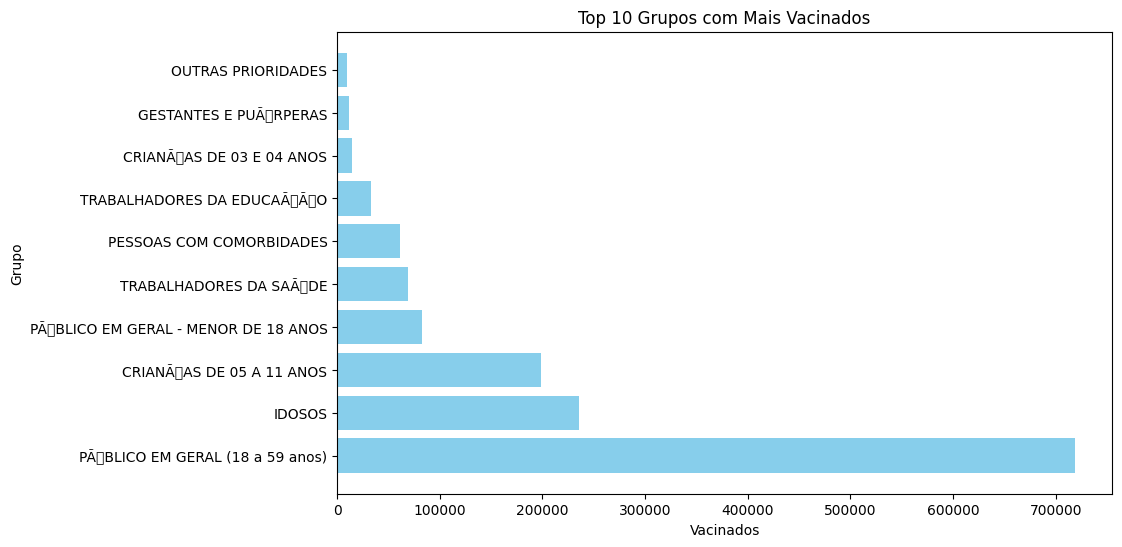

In [66]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd

# Inicialização do SparkSession
spark = SparkSession.builder.appName('VisualizacaoGrupo').getOrCreate()

# Carregar dados do CSV para DataFrame do Spark
df = spark.read.csv('vacinados.csv', encoding='ISO-8859-1', sep=';', header=True, inferSchema=True)

# Calcular a contagem de vacinados por grupo
vc_grupo = df.groupBy('grupo').count().orderBy('count', ascending=False)

# Selecionar os 10 grupos mais frequentes
vc_grupo = vc_grupo.limit(10)

# Coletar os resultados para um DataFrame Pandas para plotagem
vc_grupo_pd = vc_grupo.toPandas()

# Plotar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))
plt.barh(vc_grupo_pd['grupo'], vc_grupo_pd['count'], color='skyblue')
plt.xlabel('Vacinados')
plt.ylabel('Grupo')
plt.title('Top 10 Grupos com Mais Vacinados')
plt.show()